In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from cv2 import PSNR as cv2_psnr

# Testes de processamento de imagens

In [2]:
df = pd.read_csv("../../outputs/mamografia/mias/metadata_mias.csv")
df.dropna(subset=['cropped_image_path'], inplace=True)

df.head()

,id,background_tissue,abnormality_type,pathology,x_center_abnormality,y_center_abnormality,radius,image_path,cropped_image_path,roi_image_path
0,mdb001,Fatty-glandular,Well-defined/circumscribed masses,benign,535.0,425.0,197.0,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...
1,mdb002,Fatty-glandular,Well-defined/circumscribed masses,benign,522.0,280.0,69.0,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...
4,mdb005,Fatty,Well-defined/circumscribed masses,benign,477.0,133.0,30.0,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...
5,mdb005,Fatty,Well-defined/circumscribed masses,benign,500.0,168.0,26.0,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...
10,mdb010,Fatty,Well-defined/circumscribed masses,benign,525.0,425.0,33.0,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...,D:/mathe/Documents/banco_dados_ic/mamografia/m...


## Median Filter

In [ ]:
for i, row in df.iterrows():
    image_path = row['cropped_image_path']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    best_score_median = 0
    best_median = 0

    for j in range(3, 30, 2):
        median_image = cv2.medianBlur(image, j)
        score = cv2_psnr(image, median_image)

        if score > best_score_median:
            best_score_median = score
            best_median = j

    df.at[i, "best_median"] = best_median
    df.at[i, "best_score_median"] = best_score_median

In [ ]:
best_median = int(df['best_median'].mode().values[0])
print(f"Best median: {best_median}")
print(f"Best score median: {df['best_score_median'].mean()}")

## Clahe without median filter

In [ ]:
for i, row in df.iterrows():
    image_path = row['cropped_image_path']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    best_score_clahe = 0
    best_clip_limit = 0
    best_tile_grid_size = 0

    for clip_limit in range(1, 30):
        for tile_grid_size in range(1, 30):
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size, tile_grid_size))
            clahe_image = clahe.apply(image)
            score = cv2_psnr(image, clahe_image)

            if score > best_score_clahe:
                best_score_clahe = score
                best_clip_limit = clip_limit
                best_tile_grid_size = tile_grid_size

    df.at[i, "best_clip_limit"] = best_clip_limit
    df.at[i, "best_tile_grid_size"] = best_tile_grid_size
    df.at[i, "best_score_clahe"] = best_score_clahe

In [ ]:
best_clip_limit = df['best_clip_limit'].mode().values[0]
best_tile_grid_size = df['best_tile_grid_size'].mode().values[0]

print(f"Best clip limit: {best_clip_limit}")
print(f"Best tile grid size: {best_tile_grid_size}")
print(f"Best score clahe: {df['best_score_clahe'].mean()}")

## Clahe with median filter

In [ ]:
for i, row in df.iterrows():
    image_path = row['cropped_image_path']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    median_image = cv2.medianBlur(image, best_median)

    best_score_clahe = 0
    best_clip_limit = 0
    best_tile_grid_size = 0

    for clip_limit in range(1, 16):
        for tile_grid_size in range(1, 17):
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size, tile_grid_size))
            clahe_image = clahe.apply(median_image)
            score = cv2_psnr(image, clahe_image)

            if score > best_score_clahe:
                best_score_clahe = score
                best_clip_limit = clip_limit
                best_tile_grid_size = tile_grid_size

    df.at[i, "best_clip_limit"] = best_clip_limit
    df.at[i, "best_tile_grid_size"] = best_tile_grid_size
    df.at[i, "best_score_clahe"] = best_score_clahe

In [ ]:
best_clip_limit = df['best_clip_limit'].mode().values[0]
best_tile_grid_size = df['best_tile_grid_size'].mode().values[0]

print(f"Best clip limit: {best_clip_limit}")
print(f"Best tile grid size: {best_tile_grid_size}")
print(f"Best score clahe: {df['best_score_clahe'].mean()}")

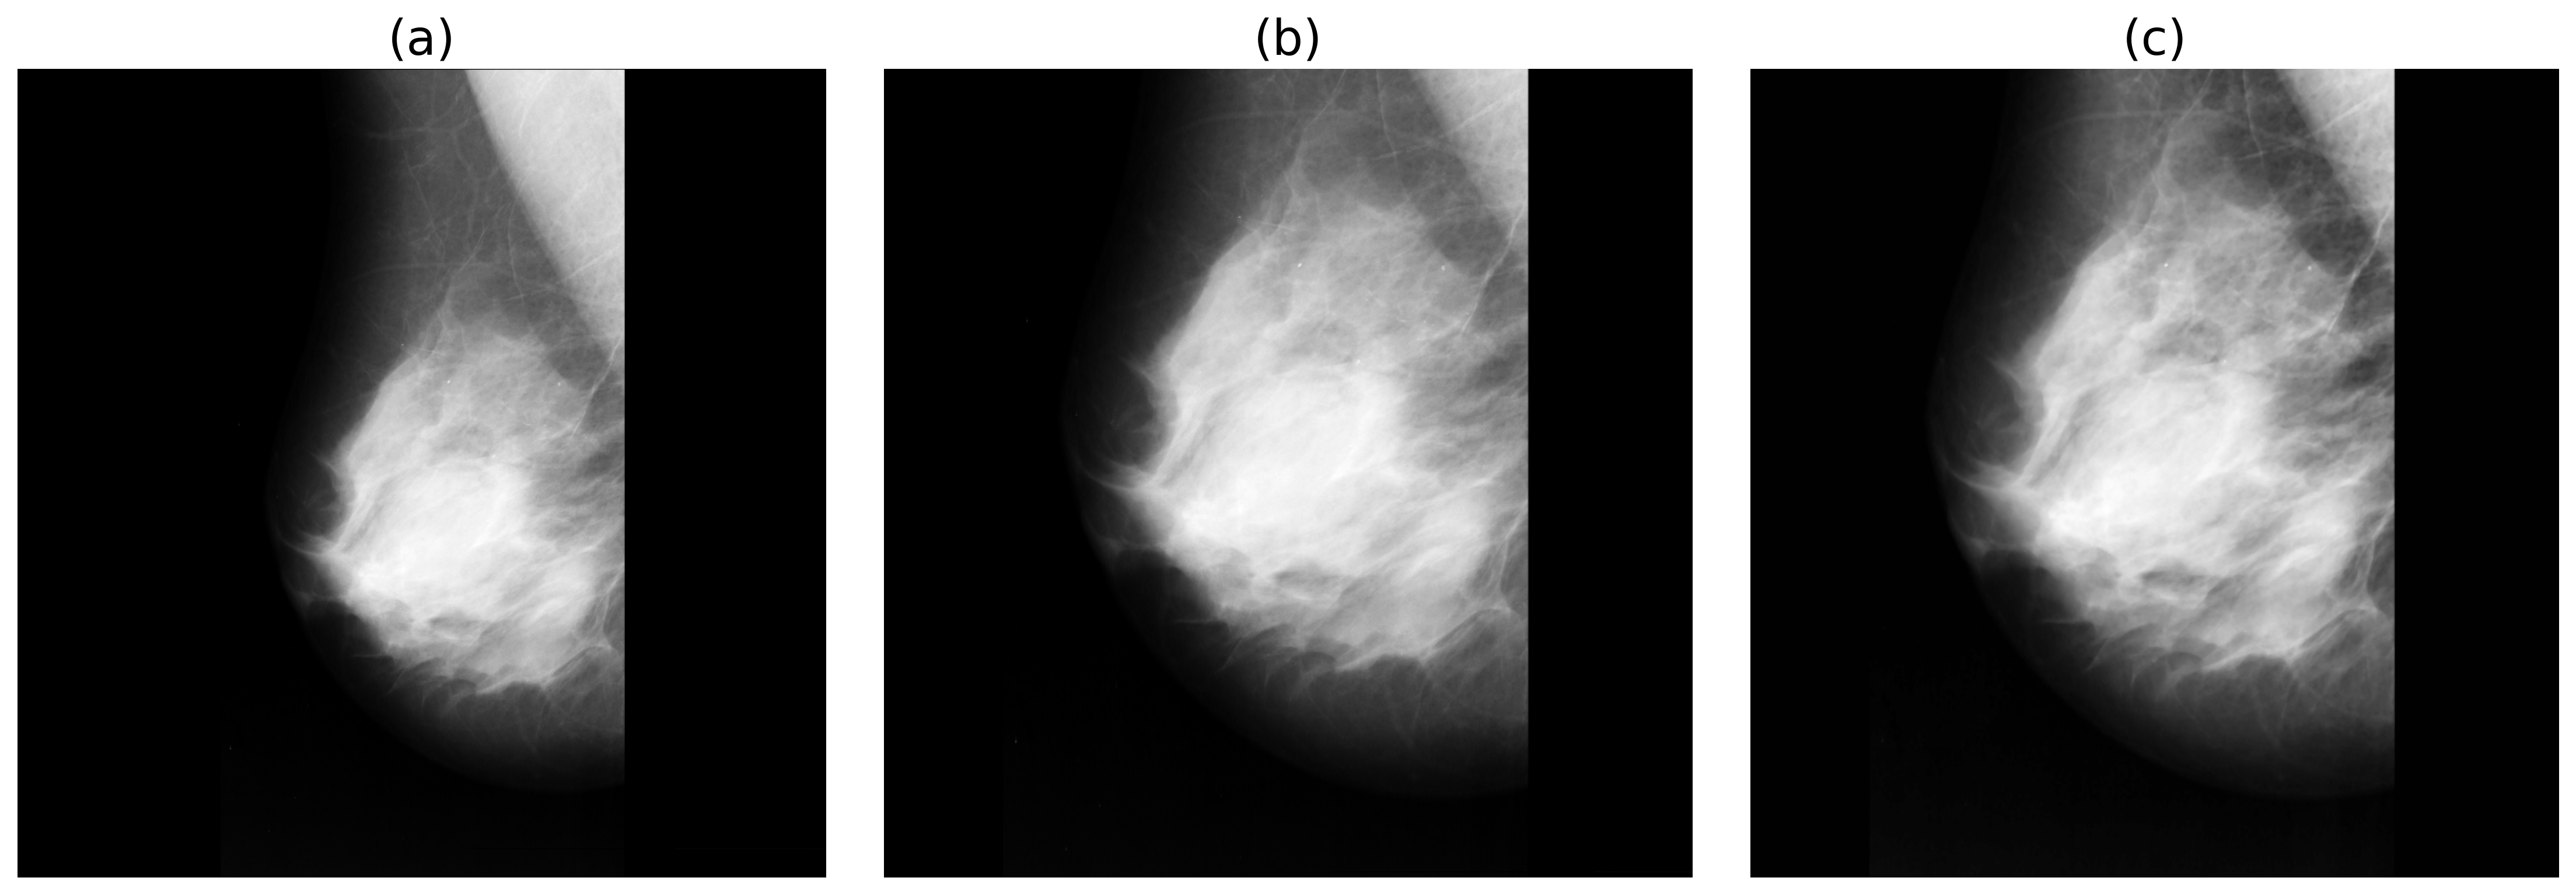

In [21]:
image_original = cv2.imread(df['image_path'].values[0], cv2.IMREAD_GRAYSCALE)
cropped_image = cv2.imread(df['cropped_image_path'].values[0], cv2.IMREAD_GRAYSCALE)

median_image = cv2.medianBlur(cropped_image, 3)
clahe_image = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(6, 6)).apply(median_image)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

axs[0].imshow(image_original, cmap='gray')
axs[0].set_title("(a)", size=20)
axs[0].axis('off')

axs[1].imshow(cropped_image, cmap='gray')
axs[1].set_title("(b)", size=20)
axs[1].axis('off')

axs[2].imshow(clahe_image, cmap='gray')
axs[2].set_title("(c)", size=20)
axs[2].axis('off')

plt.tight_layout()
plt.show()